# AI segmentation construct

## aims

In this tutorial you will 
1. Watch tutorials on segmentation of fluorescence images using AI
2. Answer questionnaire
3. Organization and vizualization of the data
4. Reconstruction of nuclei shape with star-convex polygons
5. Training of a StarDist model for nuclei segmentation
6. Evaluation and testing of the network
7. More resources

## warnings 

Make sure MPLBACKEND is not defined as `agg` otherwise you will see no graphical output!
To make sure of this, run the following command before invoking `jupyter lab`:

```sh
export MPLBACKEND=
```
or use the following parameters when importing matplotlib : 

import matplotlib <br>
import matplotlib.pyplot as plt <br>
%matplotlib inline <br>
%config InlineBackend.figure_format = 'retina' <br>


## credits

Marcelo Nollmann & JB Fiche, August 2021 <br>
Uwe Schmidt https://github.com/stardist/stardist/ <br>
Anna Kreshuk https://github.com/kreshuklab/teaching-dl-course-2020


### 0 - Preliminary requirement

Make sure you are confortable with image manipulation with python


### 1- Resources on StarDist and Deep Learning

- A quick introduction to Deep Learning : https://www.youtube.com/watch?v=5tvmMX8r_OM 
- A detailed presentation of StarDist network by Martin Weigert (first 30 minutes of the viedo): https://www.youtube.com/watch?v=Amn_eHRGX5M

### 2- Questionnaire

Plase answer the following questions
- What is the difference between Training and Testing for Deep Learning?
- What does epoch stands for?
- What is the loss function?
- What is a convolution network and why it is interesting for image analysis?
- StarDist is performing instance image segmentation. What does it mean?


### 3- Organization and vizualization of the data

A selection of fluorescence 2D images of nuclei stained with DAPI was prepared. Each original fluorescence image is paired with a mask, an image where all the nuclei have been manually segmented. The masks define the ground-truth, the ideal representation from which the network will learn how to recognize nuclei. 
Below, we are downloading a training set containing 50 pairs of images and masks for the training of StarDist. 

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["image.interpolation"] = None
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file

from stardist import fill_label_holes, random_label_cmap
lbl_cmap = random_label_cmap()

# Download the data originally used for the StarDist paper. The data are organized in two subsets :
# - the training data, used to train the network
# - the testing data, used to test whether the network was properly trained and is able to segment new images
# For each set, two types of images are available :
# - the raw data (X, X_test), i.e. original fluorescence images of nuclei in our case
# - the ground-truth or label or mask (Y, Y_test), i.e. the annotated images where the nuclei have been manually segmented.

download_and_extract_zip_file(
    url       = 'https://github.com/stardist/stardist/releases/download/0.1.0/dsb2018.zip',
    targetdir = 'data',
    verbose   = 1,
)

X = sorted(glob('data/dsb2018/train/images/*.tif'))
Y = sorted(glob('data/dsb2018/train/masks/*.tif'))
X_test = sorted(glob('data/dsb2018/test/images/*.tif'))
Y_test = sorted(glob('data/dsb2018/test/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

X = list(map(imread,X))
Y = list(map(imread,Y))
X_test = list(map(imread,X_test))
Y_test = list(map(imread,Y_test))

print('There is a total of {} images for the training set and {} images for the testing.'.format(len(X), len(X_test)))


Files found, nothing to download.
There is a total of 447 images for the training set and 50 images for the testing.


An example of image & mask is displayed below. Note that the mask is representing each nuclei with a different colour :
- if a pixel is not associated to a nuclei, its value is set to 0 = black
- then, each nuclei is assigned a unique pixel value. This way, each object can be easily differentiated. 

23 nuclei have been segmented on this image.


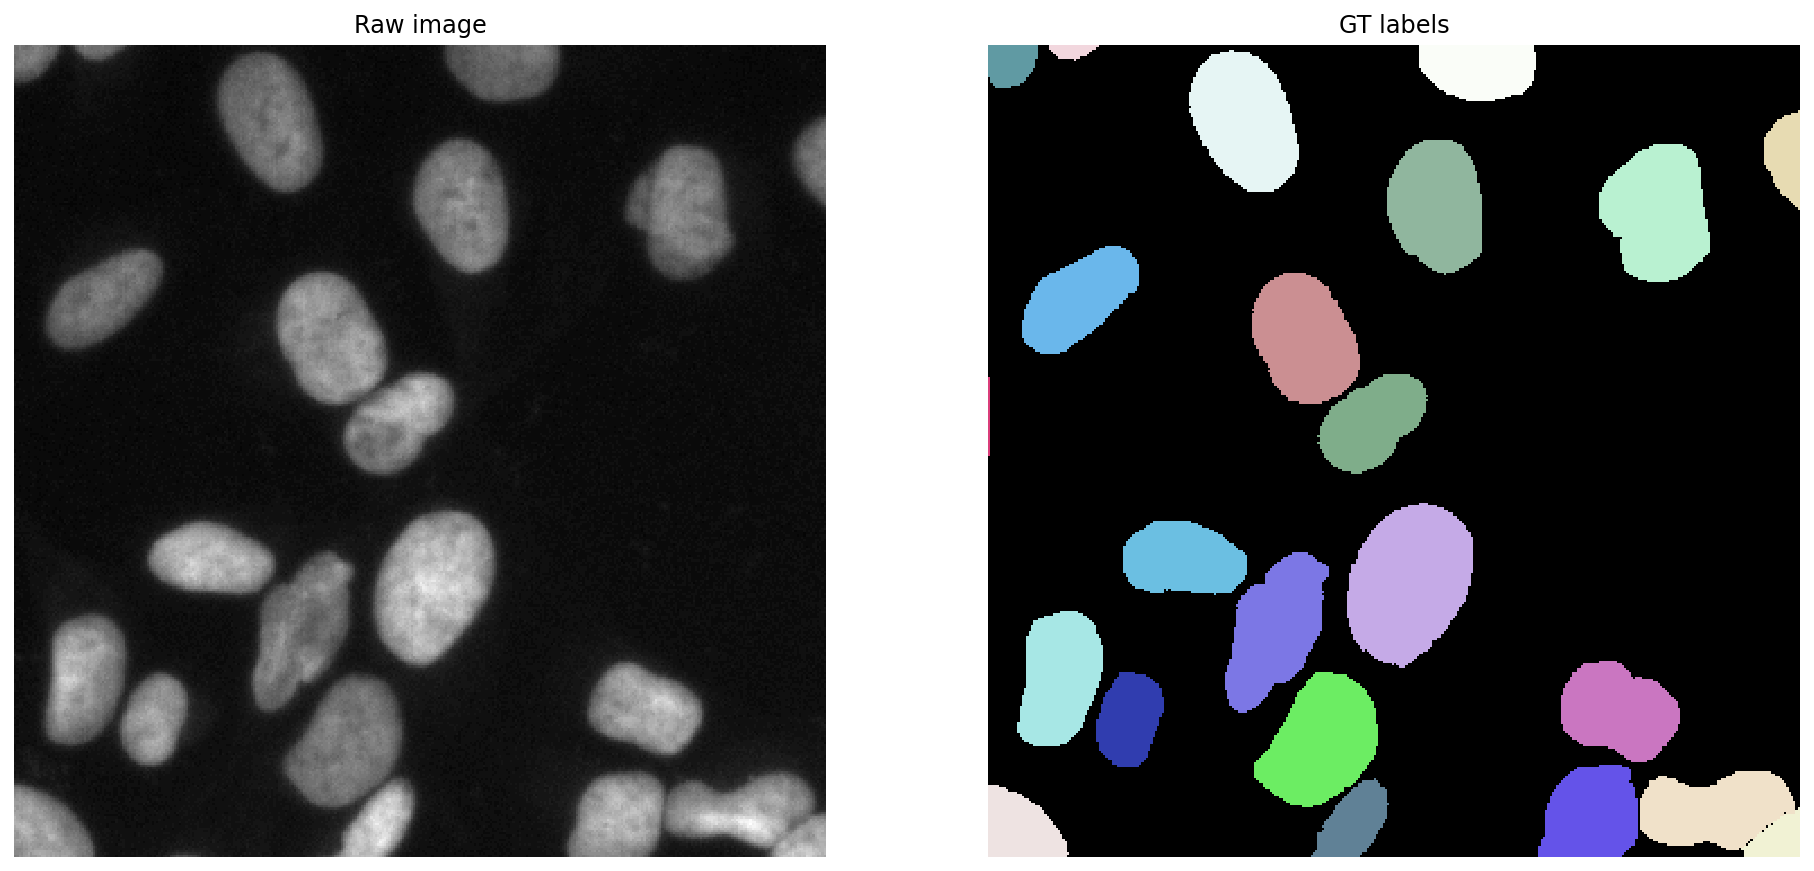

In [2]:
# Vizualization of a single image and the associated mask

i = min(4, len(X)-1)
img, lbl = X[i], fill_label_holes(Y[i])

plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')

# Count the number of nuclei segmented in the image

n_nuclei = len(np.unique(Y[i])) - 1
print('{} nuclei have been segmented on this image.'.format(n_nuclei))


### 4- Reconstruction of nuclei shape with star-convex polygons

StarDist is predicting the position and shape of every nuclei in the image. The shape of each nucleus is approximated by a star-convex polygon. The quality of the fit depends on the number of rays used to define the polygons. The higher the number of rays, the better the approximation. However, the computational time will increase with the number of rays.
In the following example, nuclei are reconstructed by polygons with varying number of rays. The optimal representation is obtained for 32 rays. 

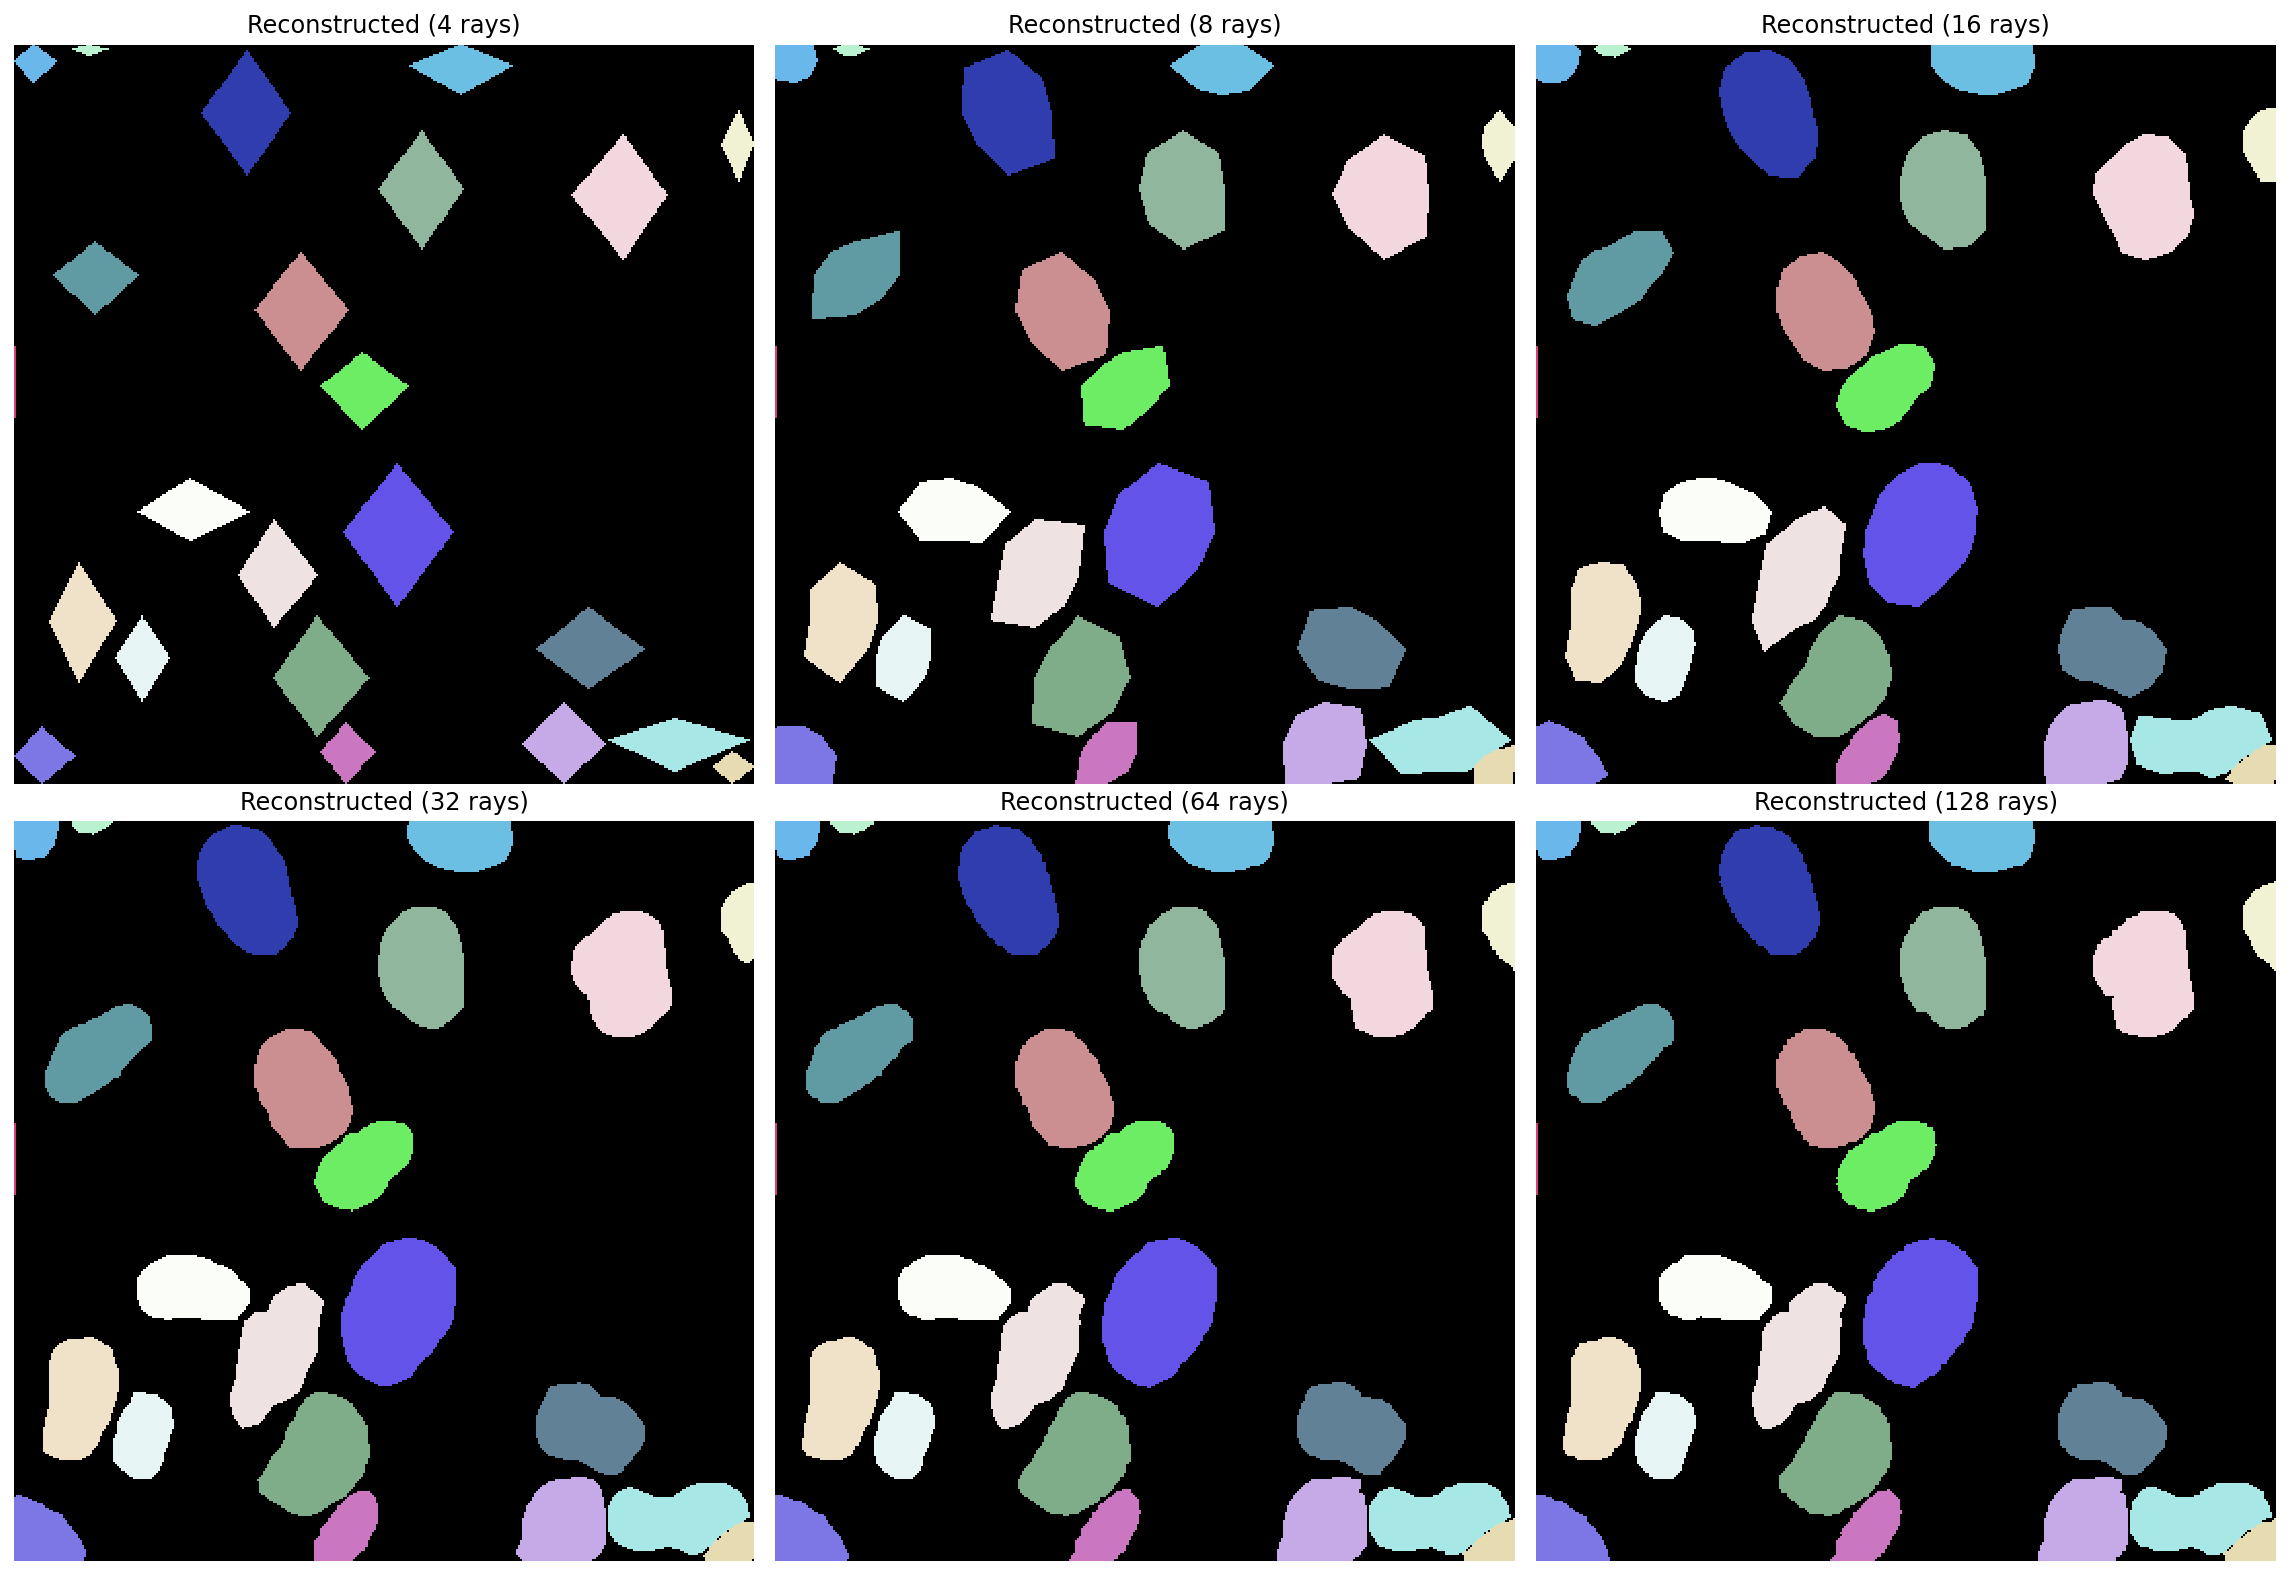

In [3]:
from stardist import relabel_image_stardist

n_rays = [2**i for i in range(2,8)]
fig, ax = plt.subplots(2,3, figsize=(16,11))
for a,r in zip(ax.flat,n_rays):
    a.imshow(relabel_image_stardist(lbl, n_rays=r), cmap=lbl_cmap)
    a.set_title('Reconstructed (%d rays)' % r)
    a.axis('off')
plt.tight_layout();

### 5- Training of a StarDist model for nuclei segmentation

In the following section, the parameters for the StarDist network are defined :
- n_rays will define the number of rays used to reconstruct the shape of the nuclei
- grid is indicating whether the images are used with their original size (1,1) or if a subsample is used. For example, a grid of (2,2) means that the size of each image will be reduced by a factor of 2 in X and Y. This operation can help accelerate the calculation without reducing the performances of the network.  

In [4]:
from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays          = n_rays,
    grid            = grid,
    use_gpu         = use_gpu,
    n_channel_in    = 1,
)

model = StarDist2D(conf, name='stardist', basedir='models')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


base_model.py (148): output path for model already exists, files may be overwritten: /home/jb/Repositories/qBioMaster-introduction/constructs/UE_Introduction/models/stardist


Since the imaging conditions depend on the sample and the microscope, there is an important variability in fluorescence intensity between images. Therefore, before launching the training, we need to perform a normalization operation on all images (https://en.wikipedia.org/wiki/Normalization_(image_processing). This operation is critical for generalization of the network.  

In [5]:
from tqdm import tqdm
from csbdeep.utils import Path, normalize

X = [normalize(x,1,99.8,axis=(0,1)) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 447/447 [00:01<00:00, 234.61it/s]


For the training, in order to limit the memory usage, the network is not going to work on large images but on small patches. The size of the patch, called receptive field or network field of view (https://theaisummer.com/receptive-field/), is defined by the architecutre of the network and parameters such as the grid size defined earlier. However, it is important to make sure that the network field of view is large enough to englobe large nuclei. <br>
Below, the median size of the nuclei is calculated and compare to the receptive field of the network. If the receptive field is too small, the parameters need to be changed (for example by increasing the size of the grid).

In [6]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [17.5 18. ]
network field of view :  [93 94]


For the training, the data X,Y are split in two :
- the training data X_trn, Y_trn will be fed to the network in order to recognize the features associated to the nuclei
- the validation data X_val, Y_val will be used during the training to monitor how the network is learning

As a rule of thumbs, ~15/20% of the data are used for the validation. <br>
For the example below, 200 epochs have been used. Note that the training could take more than 30 minutes before completion.

In [ ]:
ind = np.random.permutation(len(X))
n_val = max(1, int(round(0.15 * len(X))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]

X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

n_epochs = 200
steps = 10

history = model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), epochs=n_epochs, steps_per_epoch=steps)

### 6- Evaluation and testing of the network

After the training, we can check the network was able to learn on the data by plotting the loss for the training and validation data. The fact that the loss is decreasing during the training is an indication that the network was able to learn how to segment nuclei. <br>
After 200 epochs, the two curves (validation and training) are reaching a plateau, indicating the network is fully trained and is not able to learn more information from the data. Interestingly, the fact that both curves are overlapping until the end is an indication there was no overfitting (https://en.wikipedia.org/wiki/Overfitting). 

In [7]:
history_dict = history.history
plt.rcParams['figure.figsize'] = (10,10) # Make the figures a bit bigger

# Plot the evolution of the loss during the training

epochs = range(1, n_epochs+1)
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.figure(figsize=(8,8))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

To test whether the network is able to segment nuclei on completely new images, we are using the testing set. Below is an example where an image is segmented by the newly trained model and compared to the original groud-truth model. We can see that the model is able to segment most of the nuclei, despite the wide variety of size and shape

In [ ]:
i = min(16, len(X_test)-1)
img = normalize(X_test[i], 1,99.8, axis=(0,1))
label_predict, details = model.predict_instances(img)
label_GT = fill_label_holes(Y_test[i])

plt.figure(figsize=(16,10))
plt.subplot(121) 
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(label_predict, cmap=lbl_cmap, alpha=0.5)
plt.title('Raw image + prediction')
plt.axis('off');

plt.subplot(122) 
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(label_GT, cmap=lbl_cmap, alpha=0.5)
plt.title('Raw image + ground truth')
plt.axis('off');

### 7- More resources

- the original publication : https://arxiv.org/pdf/1806.03535.pdf
- Standford lectures on AI and deep learning : https://www.youtube.com/playlist?list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv. Lectures 1,5 & 11 are of particular interest for the segmentation.